In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from sklearn import svm
from sklearn.metrics import classification_report
import pandas as pd

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from transformers import BertTokenizer, BertModel
from transformers import Trainer, TrainingArguments

import torch
from torch.utils.data import Dataset, DataLoader

from bs4 import BeautifulSoup
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Step 1: Load and Preprocess Data
data = '/content/drive/My Drive/Colab Notebooks/LING 227: Final Project/amazon_review.csv'
reviews = pd.read_csv(data)
reviews = reviews[['reviewText', 'overall']]  # Adjust column names as needed
reviews.dropna(inplace=True)

def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

reviews['cleaned_review'] = reviews['reviewText'].apply(text_cleaning)
'''trainData['Label'] = trainData['Label'].astype(int)
testData['Label'] = testData['Label'].astype(int)
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-20-e28be4481b0c>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


"trainData['Label'] = trainData['Label'].astype(int)\ntestData['Label'] = testData['Label'].astype(int)\n"

In [ ]:
!pip install datasets
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    reviews['reviewText'].tolist(),
    reviews['overall'].tolist(),
    test_size=0.4,
    random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42
)

train_data = {"text": train_texts, "label": train_labels}
val_data = {"text": val_texts, "label": val_labels}
test_data = {"text": test_texts, "label": test_labels}

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

amazon = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
})


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2948
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 983
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 983
    })
})


In [ ]:

amazon.set_format(type="pandas")
train_df = amazon['train'][:]
valid_df = amazon['validation'][:]
test_df = amazon['test'][:]

'''
train_df['label'] = train_df['label'] - 1  # Shift labels to 0-4 (if labels were from 1 to 5)
valid_df['label'] = valid_df['label'] - 1
test_df['label'] = test_df['label'] - 1

train_df = train_df.groupby('label').apply(lambda x: x.sample(54)).reset_index(drop=True)
valid_df = valid_df.groupby('label').apply(lambda x: x.sample(13)).reset_index(drop=True)
test_df = test_df.groupby('label').apply(lambda x: x.sample(13)).reset_index(drop=True)'''

"\ntrain_df['label'] = train_df['label'] - 1  # Shift labels to 0-4 (if labels were from 1 to 5)\nvalid_df['label'] = valid_df['label'] - 1\ntest_df['label'] = test_df['label'] - 1\n\ntrain_df = train_df.groupby('label').apply(lambda x: x.sample(54)).reset_index(drop=True)\nvalid_df = valid_df.groupby('label').apply(lambda x: x.sample(13)).reset_index(drop=True)\ntest_df = test_df.groupby('label').apply(lambda x: x.sample(13)).reset_index(drop=True)"

In [ ]:
# Create feature vectors
vectorizer = TfidfVectorizer(
    min_df=5, max_df=0.8, sublinear_tf=True, use_idf=True
)

train_vectors = vectorizer.fit_transform(train_df['text'])
test_vectors = vectorizer.transform(test_df['text'])

valid_vectors = vectorizer.transform(valid_df['text'])


In [ ]:
classifier_linear = svm.SVC(kernel='linear', decision_function_shape='ovr')  # One-vs-Rest for multi-class

t0 = time.time()
classifier_linear.fit(train_vectors, train_df['label'])
t1 = time.time()

prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()

time_linear_train = t1 - t0
time_linear_predict = t2 - t1

print("Results for SVC(kernel=linear)")
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(test_df['label'], prediction_linear, output_dict=False)
print(report)

report_df = pd.DataFrame(classification_report(test_df['label'], prediction_linear, output_dict=True)).transpose()
report_df.to_csv("classification_report.csv", index=True)

Results for SVC(kernel=linear)
Training time: 4.024073s; Prediction time: 1.092658s
              precision    recall  f1-score   support

         1.0       0.67      0.43      0.53        46
         2.0       0.00      0.00      0.00        13
         3.0       0.00      0.00      0.00        26
         4.0       0.00      0.00      0.00       106
         5.0       0.83      1.00      0.91       792

    accuracy                           0.83       983
   macro avg       0.30      0.29      0.29       983
weighted avg       0.70      0.83      0.76       983



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

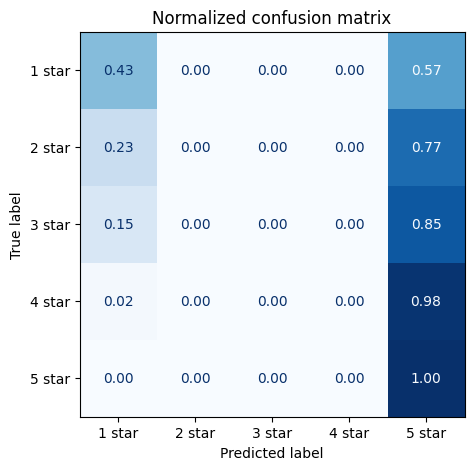

In [ ]:
label_names = ["1 star", "2 star", "3 star", "4 star", "5 star"]
label_names

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels=None):
    cm = confusion_matrix(y_true, y_preds, normalize="true")  # Normalized confusion matrix
    fig, ax = plt.subplots(figsize=(5, 5))  # Create a plot with a specific size
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)  # Display confusion matrix
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)  # Plot with blue colormap and format
    plt.title("Normalized confusion matrix")  # Set title for the plot
    plt.show()  # Show the plot

plot_confusion_matrix(prediction_linear, test_df['label'].to_numpy(), labels=label_names)
